In [149]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from sklearn import svm
from sklearn.model_selection import train_test_split

df = pd.read_csv('Phishing_Legitimate_full.csv')

In [150]:
df.shape

(10000, 50)

In [151]:
df.head(10)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1
5,6,3,1,1,42,1,0,0,0,0,...,1,1,0,1,1,1,1,-1,1,1
6,7,2,0,5,60,0,0,0,0,0,...,0,0,0,1,0,1,1,-1,-1,1
7,8,1,0,3,30,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
8,9,8,7,2,76,1,1,0,0,0,...,0,0,0,-1,-1,1,1,1,-1,1
9,10,2,0,2,46,0,0,0,0,0,...,0,0,0,1,1,1,1,-1,-1,1


In [152]:
float_cols = df.select_dtypes('float64').columns
for c in float_cols:
    df[c] = df[c].astype('float32')
    
int_cols = df.select_dtypes('int64').columns
for c in int_cols:
    df[c] = df[c].astype('int32')

In [153]:
def corr_heatmap(df, idx_s, idx_e):
    y = df['CLASS_LABEL']
    temp = df.iloc[:, idx_s:idx_e]
    if 'id' in temp.columns:
        del temp['id']
    temp['CLASS_LABEL'] = y
    sns.heatmap(temp.corr(), annot=True, fmt='.2f')
    plt.show()

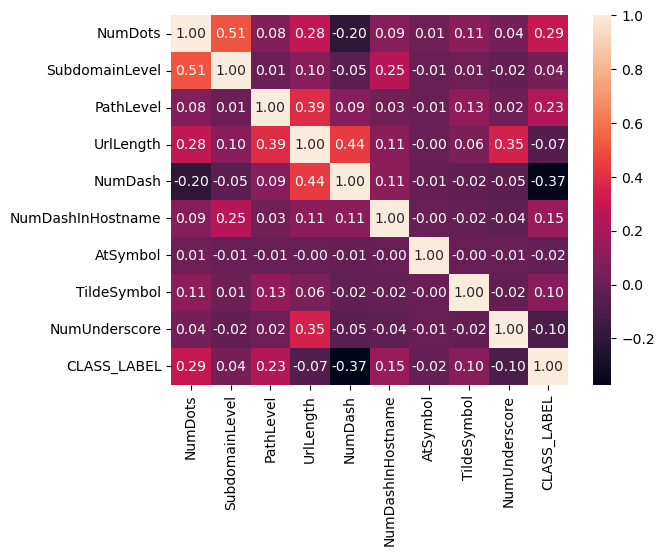

In [154]:
corr_heatmap(df, 0, 10)

In [155]:
# dropping as they are of no use
df = df.drop(['HttpsInHostname'], axis=1)

In [156]:
#g = sns.FacetGrid(df, col='CLASS_LABEL')
#g.map(plt.hist, 'ImagesOnlyInForm', bins=10)

In [157]:
# let's do binning for url_lenght

df['UrlLength_band'] = pd.cut(df['UrlLength'], 9)
df[['UrlLength_band', 'CLASS_LABEL']].groupby(['UrlLength_band'], as_index=False).mean().sort_values(by='UrlLength_band', ascending=True)

,UrlLength_band,CLASS_LABEL
0,"(11.759, 38.778]",0.488543
1,"(38.778, 65.556]",0.602101
2,"(65.556, 92.333]",0.404296
3,"(92.333, 119.111]",0.327783
4,"(119.111, 145.889]",0.390361
5,"(145.889, 172.667]",0.534091
6,"(172.667, 199.444]",0.647059
7,"(199.444, 226.222]",0.861538
8,"(226.222, 253.0]",1.000000


In [158]:
df_1 = df.copy()

In [159]:
for dataset in df_1:    
    df_1.loc[ df['UrlLength'] <= 38.778, 'UrlLength'] = 0
    df_1.loc[(df['UrlLength'] > 38.778) & (df['UrlLength'] <= 65.556), 'UrlLength'] = 1
    df_1.loc[(df['UrlLength'] > 65.556) & (df['UrlLength'] <= 92.333), 'UrlLength'] = 2
    df_1.loc[(df['UrlLength'] > 92.333) & (df['UrlLength'] <= 119.111), 'UrlLength'] = 3
    df_1.loc[(df['UrlLength'] > 92.333) & (df['UrlLength'] <= 119.111), 'UrlLength'] = 4
    df_1.loc[(df['UrlLength'] > 119.111) & (df['UrlLength'] <= 145.889), 'UrlLength'] = 5
    df_1.loc[(df['UrlLength'] > 145.889) & (df['UrlLength'] <= 172.667), 'UrlLength'] = 6
    df_1.loc[(df['UrlLength'] > 172.667) & (df['UrlLength'] <= 199.444), 'UrlLength'] = 7
    df_1.loc[(df['UrlLength'] > 199.444) & (df['UrlLength'] <= 226.222), 'UrlLength'] = 8
    df_1.loc[ df['UrlLength'] > 226.222, 'UrlLength'] = 9
df_1.head(10)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL,UrlLength_band
0,1,3,1,5,2,0,0,0,0,0,...,0,1,1,0,1,1,-1,1,1,"(65.556, 92.333]"
1,2,3,1,3,5,0,0,0,0,2,...,0,0,1,-1,1,1,1,1,1,"(119.111, 145.889]"
2,3,3,1,2,1,0,0,0,0,0,...,0,0,1,0,-1,1,-1,0,1,"(38.778, 65.556]"
3,4,3,1,6,2,1,0,0,0,0,...,0,0,1,-1,1,1,1,-1,1,"(65.556, 92.333]"
4,5,3,0,4,1,0,0,0,0,0,...,0,0,1,1,-1,0,-1,-1,1,"(38.778, 65.556]"
5,6,3,1,1,1,1,0,0,0,0,...,1,0,1,1,1,1,-1,1,1,"(38.778, 65.556]"
6,7,2,0,5,1,0,0,0,0,0,...,0,0,1,0,1,1,-1,-1,1,"(38.778, 65.556]"
7,8,1,0,3,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,"(11.759, 38.778]"
8,9,8,7,2,2,1,1,0,0,0,...,0,0,-1,-1,1,1,1,-1,1,"(65.556, 92.333]"
9,10,2,0,2,1,0,0,0,0,0,...,0,0,1,1,1,1,-1,-1,1,"(38.778, 65.556]"


In [160]:
#data.rename(columns={'CLASS_LABEL': 'labels'}, inplace=True)

In [161]:
#lower_limit = X['PathLength'].quantile(0.05)

#high_limit = X['PathLength'].quantile(0.95)

#lower_limit

In [162]:
#high_limit

In [163]:
not_helpful_columns = ['id', 'EmbeddedBrandName', 'DoubleSlashInPath', 'RightClickDisabled', 
                       'UrlLengthRT', 'ExtFavicon', 'UrlLength_band']

df_1 = df_1.drop(not_helpful_columns, axis=1)
df_1['CLASS_LABEL'].replace(0, -1, inplace=True)

In [164]:
for i in df_1:
    df_1[i] = df_1[i].astype('float32')
    
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   NumDots                             10000 non-null  float32
 1   SubdomainLevel                      10000 non-null  float32
 2   PathLevel                           10000 non-null  float32
 3   UrlLength                           10000 non-null  float32
 4   NumDash                             10000 non-null  float32
 5   NumDashInHostname                   10000 non-null  float32
 6   AtSymbol                            10000 non-null  float32
 7   TildeSymbol                         10000 non-null  float32
 8   NumUnderscore                       10000 non-null  float32
 9   NumPercent                          10000 non-null  float32
 10  NumQueryComponents                  10000 non-null  float32
 11  NumAmpersand                        10000 

In [165]:
#df_1[['DoubleSlashInPath', 'CLASS_LABEL']].groupby(['DoubleSlashInPath'], as_index=False).mean().sort_values(by='CLASS_LABEL', ascending=False)

In [166]:
accepted_columns = ['NumDots', 'SubdomainLevel', 'PathLevel', 'NumDash', 'NumPercent', 'NumDashInHostname', 
                    'NumUnderscore', 'NumQueryComponents', 'DomainInSubdomains', 'CLASS_LABEL']
#                     'UrlLength', 'AbnormalFormAction', 
#                     'DomainInPaths', 'NoHttps', 'RandomString', 'NumNumericChars', 'HostnameLength', 'NumSensitiveWords', 
#                     'PctExtHyperlinks', 'InsecureForms', 'RelativeFormAction', 'PctNullSelfRedirectHyperlinks', 
#                     'FakeLinkInStatusBar', 'PopUpWindow', 'ExtFormAction', 'SubdomainLevelRT', 'PctExtResourceUrlsRT', 
#                     'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT', 'CLASS_LABEL']

In [167]:
df_1=df_1[accepted_columns]
df_1.head(5)

,NumDots,SubdomainLevel,PathLevel,NumDash,NumPercent,NumDashInHostname,NumUnderscore,NumQueryComponents,DomainInSubdomains,CLASS_LABEL
0,3.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.0,1.0,3.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0
2,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [168]:
# df_1['AgeBand'] = pd.cut(df_1['PctNullSelfRedirectHyperlinks'], 5)
# df_1[['AgeBand', 'CLASS_LABEL']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

In [169]:
# df_1.loc[ df_1['PctNullSelfRedirectHyperlinks'] <= 0.2, 'PctNullSelfRedirectHyperlinks'] = 0
# df_1.loc[(df_1['PctNullSelfRedirectHyperlinks'] > 0.2) & (df_1['PctNullSelfRedirectHyperlinks'] <= 0.4), 'PctNullSelfRedirectHyperlinks'] = 1
# df_1.loc[(df_1['PctNullSelfRedirectHyperlinks'] > 0.4) & (df_1['PctNullSelfRedirectHyperlinks'] <= 0.6), 'PctNullSelfRedirectHyperlinks'] = 2
# df_1.loc[(df_1['PctNullSelfRedirectHyperlinks'] > 0.6) & (df_1['PctNullSelfRedirectHyperlinks'] <= 0.8), 'PctNullSelfRedirectHyperlinks'] = 3
# df_1.loc[ df_1['PctNullSelfRedirectHyperlinks'] > 0.8, 'PctNullSelfRedirectHyperlinks'] = 4

# df_1 = df_1.drop(['AgeBand'], axis=1)
# df_1.head(10)

In [170]:
X_train, X_test, Y_train, Y_test = train_test_split(df_1, df_1['CLASS_LABEL'], test_size=0.2, random_state=0)

In [171]:
# AtSymbol, TildeSymbol, NumHash, NumAmpersand, IpAddress, 
#HostnameLength
# giving low accuracy PathLength, QueryLength, RelativeFormAction
# PctExtNullSelfRedirectHyperlinksRT, PctExtResourceUrls, FrequentDomainNameMismatch, AbnormalFormAction

# mat1 and mat2 shapes cannot be multiplied (1x0 and 1x1)
# ExtFormAction

In [172]:
def getPositivePosterior(x, mu1, mu2, cov1, cov2, positive_prior):
    """Returns the positive posterior p(y=+1|x)."""
    conditional_positive = np.exp(-0.5 * (x - mu1).T.dot(np.linalg.inv(cov1)).dot(x - mu1)) / np.sqrt(np.linalg.det(cov1)*(2 * np.pi)**x.shape[0])
    conditional_negative = np.exp(-0.5 * (x - mu2).T.dot(np.linalg.inv(cov2)).dot(x - mu2)) / np.sqrt(np.linalg.det(cov2)*(2 * np.pi)**x.shape[0])
    marginal_dist = positive_prior * conditional_positive + (1 - positive_prior) * conditional_negative
    positivePosterior = conditional_positive * positive_prior / marginal_dist
    return positivePosterior

In [173]:
class LinearNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearNetwork, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [174]:
def getAccuracy(x_test, y_test, model):
    """Calculates the classification accuracy."""
    predicted = model(Variable(torch.from_numpy(x_test)))
    accuracy = np.sum(torch.sign(predicted).data.numpy() == np.matrix(y_test).T) * 1. / len(y_test)
    return accuracy

In [175]:
def pconfClassification(inputSize, num_epochs, lr, x_train_p, x_test, y_test, r):
    model = LinearNetwork(input_size=inputSize, output_size=1)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    for epoch in range(num_epochs):
        inputs = Variable(torch.from_numpy(x_train_p))
        confidence = Variable(torch.from_numpy(r))
        optimizer.zero_grad()
        negative_logistic = nn.LogSigmoid()
        logistic = -1. * negative_logistic(-1. * model(inputs))
        loss = torch.sum(-model(inputs)+logistic * 1. / confidence)  # note that \ell_L(g) - \ell_L(-g) = -g with logistic loss
        loss.backward()
        optimizer.step()
    params = list(model.parameters())
    accuracy = getAccuracy(x_test=x_test, y_test=y_test, model=model)
    return params, accuracy

In [176]:
def Group7_PconfClassification(num_epochs, learning_rate, confidence_cutoff, label_ColumnName, X_train, X_test, Y_train, Y_test):
  n_positive= len(X_train[X_train[label_ColumnName]==1])
  n_negative= len(X_train[X_train[label_ColumnName]==-1])
  mu1= X_train[X_train[label_ColumnName]==1].drop(label_ColumnName, axis=1).mean()
  mu2= X_train[X_train[label_ColumnName]==-1].drop(label_ColumnName, axis=1).mean()
  cov1= X_train[X_train[label_ColumnName]==1].drop(label_ColumnName, axis=1).cov()
  cov2= X_train[X_train[label_ColumnName]==-1].drop(label_ColumnName, axis=1).cov()
  x_train_p= X_train[X_train[label_ColumnName]==1].drop(label_ColumnName, axis=1)
  x_train_p= x_train_p
  x_train_p= x_train_p.to_numpy()

  # calculating the exact positive-confidence values: r
  positive_prior = n_positive/(n_positive + n_negative)
  r=[]
  x_train_n=[]
  for i in range(n_positive):
      x = x_train_p[i, :]
      x2 = getPositivePosterior(x, mu1.to_numpy(), mu2.to_numpy(), cov1.to_numpy(), cov2.to_numpy(), positive_prior)
      if x2 > confidence_cutoff:
        x_train_n.append(x_train_p[i])
        r.append(x2)

  x_train_n= np.asarray(x_train_n)
  r= np.asarray(r)
  r = np.matrix(r).T
  x_test= X_test.drop(label_ColumnName, axis=1)
  x_test= x_test.to_numpy()
  y_test= Y_test.astype('float32').to_numpy()
  param, accuracy= pconfClassification(pd.DataFrame(x_train_n).shape[1], num_epochs, learning_rate, x_train_n, x_test, y_test, r)
  return param, accuracy

In [177]:
X_train

,NumDots,SubdomainLevel,PathLevel,NumDash,NumPercent,NumDashInHostname,NumUnderscore,NumQueryComponents,DomainInSubdomains,CLASS_LABEL
7389,1.0,0.0,3.0,2.0,2.0,0.0,0.0,1.0,0.0,-1.0
9275,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2995,2.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5316,2.0,1.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,-1.0
356,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
9225,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4859,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3264,2.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9845,2.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,-1.0


In [178]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_estimators = [50, 100, 150, 200, 250, 300, 350]

XRF_train = X_train.drop("CLASS_LABEL", axis=1)
YRF_train = X_train["CLASS_LABEL"]

for val in n_estimators:
    score = cross_val_score(ensemble.RandomForestClassifier(n_estimators= val, random_state= 42), 
                            XRF_train, YRF_train, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(50): 0.857
Average score(100): 0.858
Average score(150): 0.858
Average score(200): 0.858
Average score(250): 0.859
Average score(300): 0.860
Average score(350): 0.860


In [179]:
best_accuracy_lookup = []

for i in range(0, 5):
    param, accuracy = Group7_PconfClassification(500, .001, 0.01, 'CLASS_LABEL', X_train, X_test, Y_train, Y_test)
    best_accuracy_lookup.append(accuracy)
    
for i in range(0, 5):
    print("Accuracy ", i+1, "is ", best_accuracy_lookup[i])

print("\nBest Accuracy for Pconf on Phishing Web is ", max(best_accuracy_lookup))

Accuracy  1 is  0.733
Accuracy  2 is  0.7325
Accuracy  3 is  0.733
Accuracy  4 is  0.743
Accuracy  5 is  0.733

Best Accuracy for Pconf on Phishing Web is  0.743


In [180]:
best_accuracy_lookup = []

for i in range(0, 10):
    param, accuracy = Group7_PconfClassification(500, .001, 0.01, 'CLASS_LABEL', X_train, X_test, Y_train, Y_test)
    best_accuracy_lookup.append(accuracy)
    
for i in range(0, 10):
    print("Accuracy ", i+1, "is ", best_accuracy_lookup[i])

print("\nBest Accuracy for Pconf on Phishing Web is ", max(best_accuracy_lookup))

Accuracy  1 is  0.7405
Accuracy  2 is  0.7425
Accuracy  3 is  0.7325
Accuracy  4 is  0.7425
Accuracy  5 is  0.7425
Accuracy  6 is  0.7425
Accuracy  7 is  0.733
Accuracy  8 is  0.733
Accuracy  9 is  0.7425
Accuracy  10 is  0.733

Best Accuracy for Pconf on Phishing Web is  0.7425
